In [1]:
import numpy as np
import sys 
sys.path.append('C:/Users/shado/Documents/Master Thesis/INFORM_marine-main_new/INFORM_marine-main/data/echosounder_data')  # To import from parent directory
from load_data.get_echograms_2 import get_echograms
years = 2014  
minimum_shape = 224
tuple_frequencies = (18, 38, 70, 120, 200, 333)
echograms = get_echograms(years=years, tuple_frequencies=tuple_frequencies, minimum_shape=minimum_shape) 
print(f"Number of echograms: {len(echograms)}")


Selected 10 echograms from year 2014
Number of echograms: 10


In [2]:
import os
import random
# Randomly split echograms into train/test
random.seed(42)  # Set a seed for reproducibility
Train_eg = []
test_eg = []
echogram = random.shuffle(echograms)  # Shuffle echograms randomly
for i,echogram in enumerate(echograms):
  if i < 0.8*len(echograms):
    Train_eg.append(echogram)
  else:
    test_eg.append(echogram)

#Save the echograms to files
train_dir = '/content/Inform_project_new/train'
test_dir = '/content/Inform_project_new/test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for i, echogram in enumerate(Train_eg):
 os.path.join(train_dir, f'echogram_{i}.npy')
for i, echogram in enumerate(test_eg):
  os.path.join(test_dir, f'echogram_{i}.npy')

# Print the number of echograms in each set
print('Train Echogram:', len(Train_eg))
print('Test Echogram:', len(test_eg))

Train Echogram: 8
Test Echogram: 2


In [3]:
from preprocessing.resize_and_crop import SplitResizeEchogram, generate_patch_batches
from preprocessing.normalization import db, clip, standardize_min_max
import sys
sys.path.append('C:/Users/shado/Documents/Master Thesis/INFORM_marine-main_new/INFORM_marine-main/adaptation_method')
from model_config import Configuration

#For logging purposes
run= Configuration()

data_transform = [db, clip, standardize_min_max]
split_patch_size = 224
output_patch_size = 224


#---Train set---
train_generators, num_patches_per_train_echogram = generate_patch_batches(Train_eg, split_patch_size,
                                                                          output_patch_size, data_transforms= data_transform,
                                                                          batch_size='full', verbose= False)
print('Number of patches per echogram for training:', num_patches_per_train_echogram )

#---Test set---
test_generators, num_patches_per_test_echogram = generate_patch_batches(test_eg, split_patch_size, output_patch_size,
                                                                        data_transforms= data_transform,
                                                                        batch_size='full', verbose= False)
print('Number of patches per echogram for testing:', num_patches_per_test_echogram )

print(f"Total number of training patches: {sum(num_patches_per_train_echogram)}")
print(f"Total number of testing patches: {sum(num_patches_per_test_echogram)}")



wandb: Currently logged in as: arangan18 (arangan18-university-of-oslo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Number of patches per echogram for training: [21, 16, 10, 37, 7, 7, 9, 8]
Number of patches per echogram for testing: [7, 8]
Total number of training patches: 115
Total number of testing patches: 15


Grouping Generators by Patch Limit 

In [4]:
from dataloader import BatchGeneratorDataset, GroupedGenerator, group_generators_by_patch_limit
from torch.utils.data import DataLoader

#---Training set---
print('-------Dimensions for Training set-------------')
grouped_generator_fns_train, grouped_patch_count_train = group_generators_by_patch_limit(train_generators, num_patches_per_train_echogram, 64)

train_dataset = BatchGeneratorDataset(grouped_generator_fns_train)
train_loader = DataLoader(train_dataset, batch_size = None, shuffle= True)

for labels, data, mask in train_loader:
    print('data shape:', data.shape )    
    
#---Test Set---
print('-------Dimensions for Test set-------------')
grouped_generator_fns_test, grouped_patch_count_test = group_generators_by_patch_limit(test_generators, num_patches_per_test_echogram, 64)

test_dataset = BatchGeneratorDataset(grouped_generator_fns_test)
test_loader = DataLoader(test_dataset, batch_size = None, shuffle= True)

for labels, data, mask in test_loader:
    print('data shape:', data.shape )



-------Dimensions for Training set-------------
data shape: torch.Size([60, 6, 224, 224])
data shape: torch.Size([47, 6, 224, 224])
data shape: torch.Size([8, 6, 224, 224])
-------Dimensions for Test set-------------
data shape: torch.Size([15, 6, 224, 224])


In [ ]:
"""
#from adaptation_method.train_autoencoder import train_val_encoder
from adaptation_method.train_autoencoder import train_val_encoder, plot_loss
from adaptation_method.Autoencoder import ResNetAutoEncoder
import torch.optim as optim
import torch.nn as nn


#Instantiating model
model = ResNetAutoEncoder()

# Defining Loss function and optimizer
Loss_func = nn.MSELoss()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                       lr= run.config['learning_rate'], 
                       weight_decay= run.config['Weight_decay']
)

encoded, avg_loss_train, val_encoded, avg_loss_val, epoch_stop = train_val_encoder(model, optimizer, Loss_func, run.config['epochs'], train_loader, test_loader, run)

plot_loss(run.config['epochs'], avg_loss_train, avg_loss_val, epoch_stop)
"""

"\n#from adaptation_method.train_autoencoder import train_val_encoder\nfrom adaptation_method.train_autoencoder import train_val_encoder, plot_loss\nfrom adaptation_method.Autoencoder import ResNetAutoEncoder\nimport torch.optim as optim\nimport torch.nn as nn\n\n\n#Instantiating model\nmodel = ResNetAutoEncoder()\n\n# Defining Loss function and optimizer\nLoss_func = nn.MSELoss()\n\noptimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), \n                       lr= run.config['learning_rate'], \n                       weight_decay= run.config['Weight_decay']\n)\n\nencoded, avg_loss_train, val_encoded, avg_loss_val, epoch_stop = train_val_encoder(model, optimizer, Loss_func, run.config['epochs'], train_loader, test_loader, run)\n\nplot_loss(run.config['epochs'], avg_loss_train, avg_loss_val, epoch_stop)\n"

lr 0.001
weight decay 0.0001
epochs 20


Epoch 1/20: 100%|██████████| 3/3 [00:31<00:00, 10.67s/it]


Train encodings: min=0.0001, max=0.9998
Val latents: min=0.0031, max=0.9938
 Train Loss = 0.0932 ,Validation Loss = 0.0913


Epoch 2/20: 100%|██████████| 3/3 [00:30<00:00, 10.31s/it]


Train encodings: min=0.0056, max=0.9889
Val latents: min=0.0076, max=0.9848
 Train Loss = 0.0568 ,Validation Loss = 0.0569


Epoch 3/20: 100%|██████████| 3/3 [00:26<00:00,  8.89s/it]


Train encodings: min=0.0079, max=0.9843
Val latents: min=0.0099, max=0.9802
 Train Loss = 0.0410 ,Validation Loss = 0.0445


Epoch 4/20: 100%|██████████| 3/3 [00:31<00:00, 10.45s/it]


Train encodings: min=0.0136, max=0.9729
Val latents: min=0.0177, max=0.9628
 Train Loss = 0.0323 ,Validation Loss = 0.0378


Epoch 5/20: 100%|██████████| 3/3 [00:33<00:00, 11.22s/it]


Train encodings: min=0.0212, max=0.9576
Val latents: min=0.0238, max=0.9452
 Train Loss = 0.0243 ,Validation Loss = 0.0309


Epoch 6/20: 100%|██████████| 3/3 [00:42<00:00, 14.15s/it]


Train encodings: min=0.0256, max=0.9489
Val latents: min=0.0283, max=0.9262
 Train Loss = 0.0242 ,Validation Loss = 0.0279


Epoch 7/20: 100%|██████████| 3/3 [00:32<00:00, 10.68s/it]


Train encodings: min=0.0293, max=0.9397
Val latents: min=0.0272, max=0.9256
 Train Loss = 0.0225 ,Validation Loss = 0.0274


Epoch 8/20: 100%|██████████| 3/3 [00:32<00:00, 10.79s/it]


Train encodings: min=0.0264, max=0.9462
Val latents: min=0.0221, max=0.9444
 Train Loss = 0.0224 ,Validation Loss = 0.0211


Epoch 9/20: 100%|██████████| 3/3 [00:30<00:00, 10.01s/it]


Train encodings: min=0.0197, max=0.9605
Val latents: min=0.0197, max=0.9562
 Train Loss = 0.0238 ,Validation Loss = 0.0260


Epoch 10/20: 100%|██████████| 3/3 [00:31<00:00, 10.54s/it]


Train encodings: min=0.0188, max=0.9623
Val latents: min=0.0170, max=0.9658
 Train Loss = 0.0222 ,Validation Loss = 0.0251


Epoch 11/20: 100%|██████████| 3/3 [00:32<00:00, 10.88s/it]


Train encodings: min=0.0159, max=0.9681
Val latents: min=0.0124, max=0.9752
 Train Loss = 0.0203 ,Validation Loss = 0.0246


Epoch 12/20: 100%|██████████| 3/3 [01:00<00:00, 20.07s/it]


Train encodings: min=0.0082, max=0.9837
Val latents: min=0.0078, max=0.9844
 Train Loss = 0.0197 ,Validation Loss = 0.0236


Epoch 13/20: 100%|██████████| 3/3 [00:42<00:00, 14.33s/it]


Train encodings: min=0.0049, max=0.9902
Val latents: min=0.0046, max=0.9908
 Train Loss = 0.0201 ,Validation Loss = 0.0186


Epoch 14/20: 100%|██████████| 3/3 [00:50<00:00, 16.83s/it]


Train encodings: min=0.0033, max=0.9933
Val latents: min=0.0025, max=0.9949
 Train Loss = 0.0175 ,Validation Loss = 0.0179


Epoch 15/20: 100%|██████████| 3/3 [00:53<00:00, 17.93s/it]


Train encodings: min=0.0022, max=0.9956
Val latents: min=0.0015, max=0.9971
 Train Loss = 0.0182 ,Validation Loss = 0.0247


Epoch 16/20: 100%|██████████| 3/3 [00:29<00:00,  9.97s/it]


Train encodings: min=0.0011, max=0.9979
Val latents: min=0.0009, max=0.9982
 Train Loss = 0.0194 ,Validation Loss = 0.0239


Epoch 17/20: 100%|██████████| 3/3 [00:30<00:00, 10.12s/it]


Train encodings: min=0.0006, max=0.9988
Val latents: min=0.0006, max=0.9988
 Train Loss = 0.0182 ,Validation Loss = 0.0183


Epoch 18/20: 100%|██████████| 3/3 [00:37<00:00, 12.44s/it]


Train encodings: min=0.0005, max=0.9991
Val latents: min=0.0005, max=0.9990
 Train Loss = 0.0142 ,Validation Loss = 0.0200


Epoch 19/20: 100%|██████████| 3/3 [00:40<00:00, 13.40s/it]


Train encodings: min=0.0004, max=0.9991
Val latents: min=0.0005, max=0.9991
 Train Loss = 0.0146 ,Validation Loss = 0.0151


Epoch 20/20: 100%|██████████| 3/3 [00:55<00:00, 18.51s/it]


Train encodings: min=0.0004, max=0.9992
Val latents: min=0.0004, max=0.9991
 Train Loss = 0.0140 ,Validation Loss = 0.0144


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▅▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▂▂▂▂▂▁▁▂▂▁▂▁▁
epoch,20
train_loss,0.01401
val_loss,0.01445


Total training time: 856.5 seconds
Average time per epoch: 42.8 seconds


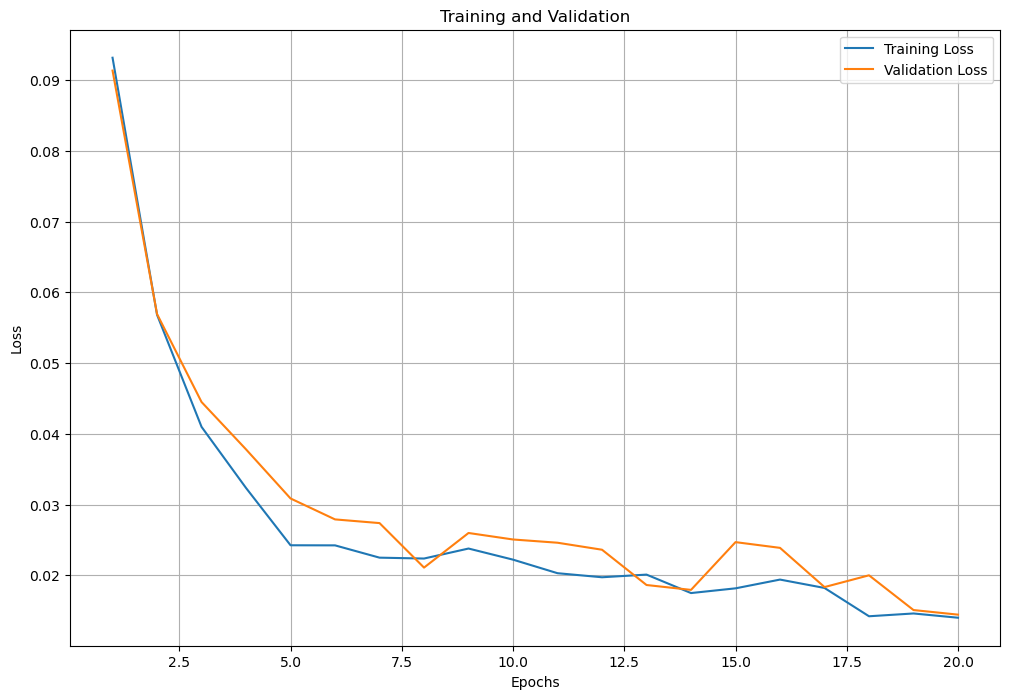

In [5]:
from train_autoencoder import train_val_encoder, plot_loss
from adaptation_method.Autoencoder import Autoencoder
import torch
import torch.nn as nn
import torch.optim as optim
import time


#Instantiating model
model = Autoencoder()

# Defining Loss function and optimizer
Loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = run.config['learning_rate'], weight_decay = run.config['Weight_decay'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('lr', run.config['learning_rate'])
print('weight decay', run.config['Weight_decay'])
print('epochs', run.config['epochs'])


total_start= time.perf_counter()
train_latent, val_latent, avg_loss_train,  avg_loss_val, stop_epoch = train_val_encoder(model, optimizer, Loss_func, run.config['epochs'], train_loader, test_loader, run, device = device)

#Timing the whole training process
if torch.cuda.is_available() and device.type == 'cuda':
    torch.cuda.synchronize()
total_time = time.perf_counter() - total_start
print(f"Total training time: {total_time:.1f} seconds")
print(f"Average time per epoch: {total_time/run.config['epochs']:.1f} seconds")

plot_loss(run.config['epochs'], avg_loss_train, avg_loss_val, stop_epoch)


In [ ]:
print('Shape of latent representation for training set:', train_latent.shape)
print('Shape of latent representation for validation set:', val_latent.shape)

train_latent = train_latent.permute(1,0,2,3).contiguous()  # (num_patches, num_freq, height, width) -> (num_freq, num_patches, height, width)


Shape of latent representation for training set: torch.Size([75, 3, 224, 224])
Shape of latent representation for validation set: torch.Size([58, 3, 224, 224])


In [ ]:
from pretrained_models.get_embeddings import get_embeddings
from pretrained_models.load_vit_model import load_vit_model
from pretrained_models.select_model import select_model
